In [1]:
import gym
from gym import Env

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from enum import Enum
import cv2 as cv

In [70]:
class GameEnvV1(Env):
    def __init__(self, m, n, initial_pos):
        super(GameEnvV1, self).__init__()
        self.grid = np.zeros(tuple([m, n]))
        self.rows = m;
        self.cols = n;
        self.action_space = {  # agent position is a number between 1 and m * n 
            'Up': -self.cols,   # moving up makes us move across m cells (if they were laid out in a line)
            'Down': self.cols,
            'Left': -1,
            'Right': 1,
            'Stall': 0}
        #self.T = np.zeros(self.action_space) # action counts
        #self.est_values = np.zeros(self.action_space) # value Q(a)
        self.reward = {  # 4 rewards.
            (m - 1, n - 1): 10,
            (1, 1): -1,
            (0, 2): 1,
            (2, 1): 3
        }
        self.grid[self.get_coordinate_from_position(initial_pos)] = 1
        for reward_loc in self.reward.keys():
            if self.reward[reward_loc] > 2:
                self.grid[reward_loc] = 10 * self.reward[reward_loc] 
        self.agent_position = initial_pos

    def get_coordinate_from_position(self, pos):
        m = pos // self.cols
        n = pos % self.cols
        return (m, n)

    def is_action_possible(self, action):  # might not be needed. Added for later convenience 
#         print(f'is possible? {action}')
        if action not in self.action_space.keys():
            return False;

        if self.agent_position % self.cols == 0 and action == 'Left':
            # can't move left as we are at the edge
            return False;
        
        if self.agent_position % self.cols == self.cols - 1 and action == 'Right':
            # can't move right as we are at the edge
            return False;
        
        if self.agent_position % self.rows == 0 and action == 'Up':
            # can't move up as we are at the 1st row
            return False;
        
        if self.agent_position % self.rows == self.rows - 1 and action == 'Down':
            # can't move down as we are at the last row
            return False;
        
        return True;
    
    def step(self, action):
        if not self.is_action_possible(action):
            return self.grid, 0, False, {};
        
        self.agent_position += self.action_space[action];

        reward = -1
        m, n = self.get_coordinate_from_position(self.agent_position)
        if (m, n) in self.reward:
            reward = self.reward[(m, n)];

        terminal = False;
        if self.agent_position == self.rows * self.cols - 1:
            terminal = True;

        return self.grid, reward, terminal, {}

    def update_est(self, action, reward):
        self.T[action] += 1
        alpha = 1./self.T[action]
        self.est_values[action] += alpha * (reward - self.est_values[action])  # keeps running average of rewards

    def reset(self):
        self.agent_position = 0

    def render(self):
        plt.imshow(self.grid)
        # using open cv below. But it is getting too time consuming for more than 3 many elements
#         img_rows, img_cols = (501, 501)
#         rows, cols = (4, 4)

#         x = np.linspace(start=0, stop=img_rows - 1, num=rows + 1)
#         y = np.linspace(start=0, stop=img_cols - 1, num=cols + 1)

#         for line_pos in x:
#             x1 = int(line_pos)
#             y1 = 0
#             y2 = img_rows - 1
#             cv.line(newMat_3ch, (x1,y1), (x1, y2), (0,0,255),1 )  # img, start, end, col, thickness

#         for line_pos in y:
#             x1 = 0
#             y1 = int(line_pos)
#             x2 = img_cols - 1
#             cv.line(newMat_3ch, (x1, y1), (x2, y1), (255,0,0), 1)

#         cv.namedWindow('newMat_3ch',0)
#         cv.imshow('newMat_3ch', newMat_3ch)
#         cv.waitKey(0)
#         cv.destroyAllWindows()
        

In [71]:
def draw_grid(img, grid_shape, color=(0, 255, 0), thickness=1):
    h, w, _ = (250, 250, 0)
    rows, cols = grid_shape
    dy, dx = h / rows, w / cols

    # draw vertical lines
    for x in np.linspace(start=dx, stop=w-dx, num=cols-1):
        x = int(round(x))
        cv.line(img, (x, 0), (x, h), color=color, thickness=thickness)

    # draw horizontal lines
    for y in np.linspace(start=dy, stop=h-dy, num=rows-1):
        y = int(round(y))
        cv.line(img, (0, y), (w, y), color=color, thickness=thickness)

    return img

In [72]:
cv.destroyAllWindows()

In [73]:
class RandomAgent:
    def __init__(self, initialPosition, actions):
        self.position = initialPosition
        self.actions = actions

    def get_step(self):
        index =  np.random.choice(len(self.actions)) #takes a random number from the action space we created
#         print(self.actions)
        return self.actions[index]

    def choose_action(self, epsilon):
        # Epsilon-greedy policy
        return np.random.choice(self.action_space);
        # ignore below. Not working for now
        rand_num = np.random.random()
        if epsilon > rand_num: # explore
            return np.random.randint(self.action_space)
        else: # exploit
            return np.argmax(self.est_values)


In [74]:
def trainAgent(bandit, env, steps, epsilon):
    history = []
    for i in range(steps):
        action = bandit.get_step()
        state, reward, terminal, info = env.step(action)
        if terminal:
            print('Terminal state reached')
            break;
        print(f'State: {env.agent_position}, action: {action}, Reward: {reward}')
        #env.render() # prints the current state in which the agent arrived 
        #R = bandit.get_reward(action)
        #bandit.update_est(action, R)
        #history.append(R)
    #return np.array(history)

[[  1.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.  30.   0.   0.]
 [  0.   0.   0. 100.]]
 DETERMINISTIC ENVIRONMENT 
*********

State: 0, action: Left, Reward: 0
State: 4, action: Down, Reward: -1
State: 4, action: Left, Reward: 0
State: 8, action: Down, Reward: -1
State: 8, action: Left, Reward: 0
State: 8, action: Stall, Reward: -1
State: 8, action: Up, Reward: 0
State: 8, action: Left, Reward: 0
State: 8, action: Left, Reward: 0
State: 12, action: Down, Reward: -1


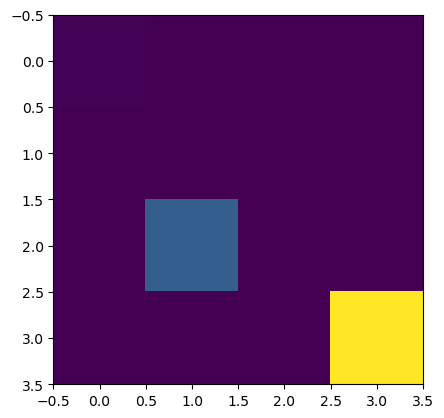

In [75]:
initial_pos = 0;
env = GameEnvV1(4, 4, initial_pos)
print(env.grid)
agent = RandomAgent(initial_pos, list(env.action_space.keys()))
env.reset()
print(" DETERMINISTIC ENVIRONMENT ")
env.render()
print("*********\n")
trainAgent(agent, env, 10, 0.1)

In [70]:
class GameEnvV2(GameEnvV1):
    def step(self, action):
        if not self.is_action_possible(action):
            return 0, False;
        if np.random.choice(4) == 0:
            action = 'Stall'
        self.agent_position += self.action_space[action];
        print(action, self.agent_position)
        
        reward = -1
        m = self.agent_position // self.cols
        n = self.agent_position % self.cols
        if (m, n) in self.reward:
            reward = self.reward[(m, n)];
            
        terminal = False;
        if self.agent_position == self.rows * self.cols - 1:
            terminal = True;

        return reward, terminal

 STOCHASTIC ENVIRONMENT 
*********

Right
Reward for this step -  -1
Up
Reward for this step -  -1
Right
Reward for this step -  -1
Stall
Reward for this step -  -1
Left
Reward for this step -  -1
Right
Reward for this step -  -1
Left
Reward for this step -  -1
Stall
Reward for this step -  -1
Right
Reward for this step -  -1
Left
Reward for this step -  -1


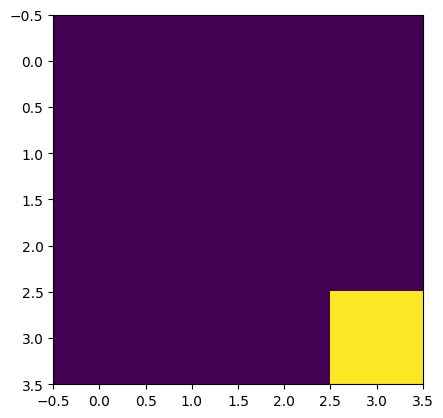

In [71]:
env = GameEnvV2(4, 4, 2)
agent = RandomAgent(env)
env.reset()
print(" STOCHASTIC ENVIRONMENT ")
env.render()
print("*********\n")
trainAgent(agent, env, 10, 0.1)